# Voice Recognition for Digits - Jimmy Fernandez and Christina Lau

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa as lb 
import matplotlib.pyplot as plt
from scipy.signal import stft
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings
import scipy.signal
import scipy.fftpack

In [3]:
warnings.filterwarnings(action='ignore') # to suppress warning messages

In [4]:
#set true if you are using a mac
Mac = False

## MFCC Feature Calculation

Before diving into the MFCC algorithm, we first write a number of simple helper functions for use at various points of the algorithm. These functions convert the FFT frequency indcies to frequency in hz, hz to mels (on the non-linear Mel frequency scale), and vice versa.

In [5]:
def binToHz(k, nfft = 2048, fs = 22050):
    """
    Helper function that takes in an fft/stft frequency bin k and returns the corresponding frequency of the bin in hertz
    
    Inputs:
    k - the index of the stft row of interest
    
    Outputs:
    freq - the frequency of the provided STFT bin
    """
    
    freq = k*fs/nfft
    
    return freq

In [6]:
def hzToBin(freq, nfft = 2048, fs = 22050):
    """
    helper function that converts the provided frequency in hz to the nearest fft frequency index. Only valid for frequencies 
    contained within the first half of the fft 
    
    Inputs:
    freq - the frequency we are interested in converting to frequency index
    nfft - the size of the fft performed
    fs - the sample rate of the signal
    
    
    Outputs:
    k - converted frequency bin
    
    """
    
    k = np.round(freq*nfft/fs)
    
    return k

In [7]:
def hzToMel(hz):
    """
    Helper function that converts the provided hz frequency to mel frequency scale
    
    Inputs:
    hz - the frequency of interst in hz
    
    Outputs:
    mel - the frequency of interest in mel
    """
    
    mel = 1125*np.log(1 + hz/700)
    
    return mel

In [8]:
def melToHz(mel):
    """
    Helper function that converts the provided mel frequency to hz frequency scale
    
    Inputs:
    mel - the frequency of interest in mel
    
    Outputs:
    hz - the frequency of interst in hz
    """
    hz = 700*(np.exp(mel/1125) - 1)
    
    return hz

Now we implement the Mel Frequency Cepstrum Coefficent calculation for the features. The algorithm has 5 main steps.

1. Take the STFT of the audio signal. This is an implied step of our function, as it is passed the STFT as an input
2. Calculate the periodogram of the STFT. The Periodogram is the elementwise square magnitude of the STFT elements divided by the length of the FFT used to construct the STFT
3. Use the "Mel Frequency Filter Bank" to calculate the energies in a specified number of frequency bands. The Mel Frequency scale is a logarithmic scale that more closely matches the way humans hear/speak. As such, the filter bank sums energies in closely related frequency bins together to express the energy content in ranges more similar to human speech, with higher frequencies having a wider range summed together than lower frequencies
4. Take the natural logarithm of the mel energy bands
5. Take the discrete cosine transform of the logarithmic mel energy bands. These are the MFCC coefficients (there should be a specified number per frame of the STFT)

In [9]:
def mfcc(S, n_fft = 2048, sr = 22050, num_coeffs = 26, filterMatrix = None, bottomFreq = 300, topFreq = 8000, epsilon = 1e-9):
    """
    Performs the calculation of the MFCC feature matrix
    
    Inputs:
    S - the STFT of the audio signal of interest
    n_fft - the length of the DFT used to calculate the STFT
    sr = the sample rate of the audio of interest
    num_coeffs - the number of coefficients to return (and also the number of Mel Filters to create)
    bottomFreq - the bottom frequency of our filter bank. Defaults to 300 hz because this is a common bottom used in speech recognition
    topFreq - the top frequency of our filter bank. Defaults to 8000 hz because this is a common top used in speech recognition
    epsilon - a small number added to the logarithm to prevent NaN's
    
    Outputs:
    mfcc - a num_coeffs x number of STFT frames matrix that represents the MFCC feature per frame of the STFT
    
    """
    #we begin by calculating the periodogram of the provided STFT matrix
    pxx= np.abs(S)**2/n_fft

    
    #use a precalculated filter matrix to make the calculation slightly more efficient, if desired
    if filterMatrix is not None:
        assert(num_coeffs == filterMatrix.shape[0])
        filt = filterMatrix
    else:
        filt = calculateFilterMatrix(numFilters = num_coeffs, bottomFreq = bottomFreq, topFreq = topFreq)
        
    #sum the relevant filter energies and take the logarithm of them (part of the "cepstrum calculation")
    mel_log_energies = np.log(filt@pxx + epsilon)
    
    mfcc = scipy.fftpack.dct(mel_log_energies, axis = 0, norm = 'ortho') #norm is set to ortho for the preimplemented version
    
    
    return mfcc

In order to perform the above calculation. We write a helper function that calculates the filter bank as a matrix that can be used to premultiply the periodogram to perform the summation an filtering. To calculate the filter bank, we do the following

1. Take our upper and lower frequency bounds and convert them to mels
2. Generate a number of linearly spaced points between the endpoints equal to the number of desired filters
3. Convert the points to hz, then to FFT frequency bins
4. iterate through the filter matrix, and starting with the leftmost points, use groups of three points as the start, stop, and peak of the triangular filter. The amplitude ranges from 0 to 1 at the peak linearly and down to zero again.

In [10]:
def calculateFilterMatrix(numFilters = 26, bottomFreq = 300, topFreq = 8000,  nfft = 2048):
    """
    Helper function for the MFCC calculation that returns a matrix of size numfilters x nfft//2 + 1
    
    Inputs:
    numFilters - the desired number of filters
    bottomFreq - the bottom frequency of the filter bank
    topFreq - the top frequency of the filter bank
    nfft - the length of the fft
    
    
    Outputs:
    filterMatrix - a numfilters x nfft//2 + 1 matrix where each row is one of mel triangular filters
    
    """
    #calculating the upper and lower bounds of our functions
    lowerbound = hzToMel(bottomFreq)
    upperbound = hzToMel(topFreq)
    
    #calculate the end/peak points for the various filters
    freq_endpoints = melToHz(np.linspace(lowerbound, upperbound, num = numFilters + 2))
    endpoints = hzToBin(freq_endpoints)
    
    #iterate through every value of the matrix
    filterMatrix = np.zeros((numFilters, nfft//2 + 1))
    for filt in range(numFilters):
        
        #retrieve end points for use in the filter calculating function
        start = endpoints[filt]
        peak = endpoints[filt + 1]
        stop = endpoints[filt + 2]
        
        #calculate the proper amplitude of the triangle filter
        for k in range(nfft//2 + 1):
            
            if k >= start and k <= peak:
                filterMatrix[filt, k] = (k - start)/(peak - start)
            elif k >= peak and k <= stop:
                filterMatrix[filt, k] = (stop - k)/(stop - peak)
            else:
                filterMatrix[filt, k] = 0
        
    
    return filterMatrix

We now test all our miscellaneous functions

(-0.5, 1024.5, -0.5, 25.5)

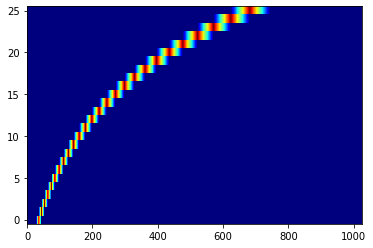

In [11]:
test = calculateFilterMatrix(numFilters = 26)
plt.imshow(test, cmap = 'jet', origin = 'lower')
plt.axis('tight')

## Word Splitting

In [12]:
def getDigitTimes(queryName, hop_length = 128, top_db = 25):
    """
    """
    audio, sr = lb.core.load(queryName)
    digits = lb.effects.split(audio, hop_length = hop_length, top_db = top_db)
    
    return digits

In [13]:
def playDigits(queryName, digitTimes, hop_length=128, sr = 22050):
    """
    """
    
    audio, sr = lb.core.load(queryName)

    for time in digitTimes:
        ipd.display(ipd.Audio(audio[time[0]:time[1]], rate = sr))
    

# Constructing the Database

To construct the database, we retrieve a list of all the mp3s in a specified directory, then iterate through them, calculating the mfcc feature matrix for each and storing it in a dictionary with a key specified in the file name

In [14]:
def retrieveMP3s(indir, Mac = False):
    """
    Helper function to retrieve a list of all the .mp3 files listed in the provided directory
    Note: For macs, it's /*.mp3, for windows, it's \*.mp3
    
    Inputs:
    indir - the directory containing all the MP3s of interst
    Mac - a boolean indicating if the machine running the code is a Mac. If false, windows notation is assumed
    
    Outputs: 
    A list of all the mp3 file paths
    
    """
    #get the correct pathname based on the machine type
    if Mac: 
        pathname = indir + '/*.mp3'
    else:
        pathname = indir + '\*.mp3'
    
    return glob.glob(pathname)

In [41]:
def constructDB(indir, Mac = False, sr = 22050, nfft = 2048, hop = 128):
    """
    Function that constructs a database (dictionary) with the digit as a key and the MFCC feature matrix as the stored data
    
    Inputs: 
    indir - the label of the directory of interest
    Mac - a boolean indicating if the machine running this code is a mac. If false, 
          it is assumed that the code is running on a pc
    sr - the sample rate of the audio files in the directory
    nfft - the size of the fft we want to perform to to construct the stft
    hop - the hop size for the stft
    
    Outputs:
    db - a dictionary object storing the MFCC coefficients for each of the digit references
    """
    
    db = {}
    mp3s = retrieveMP3s(indir, Mac = Mac)
    
    
    for i in range(len(mp3s)):
        
        #we begin by retreiving each individual mp3 and calculating the STFT
        currPath = mp3s[i]
        mp3, _ = lb.core.load(currPath, sr = sr)
        S = lb.core.stft(mp3, n_fft = nfft, hop_length = hop)
        
        #we then use calculate the MFCC feature matrix
        mfccMatrix = mfcc(S, n_fft = nfft, sr = sr)
        
        #finally we get the proper key name
        baseName = os.path.basename(currPath)
        keyName = baseName[10] #assumes the file is in Reference_x.mp3 format
        
        #add data to the database
        db[keyName] = mfccMatrix
        
    
    return db

In [42]:
#testing the db construction
db = constructDB('References', Mac = Mac)

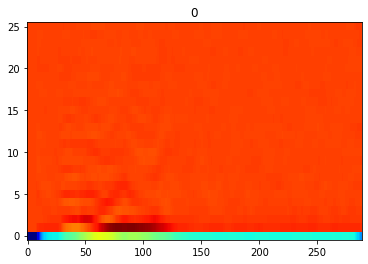

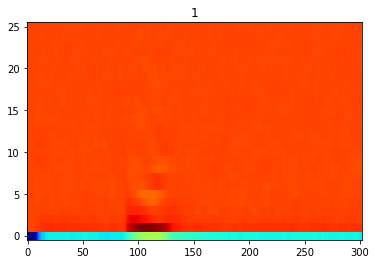

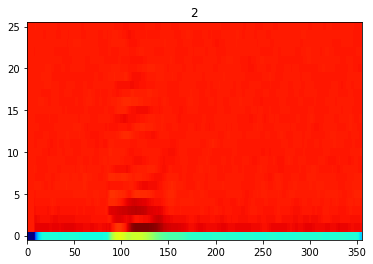

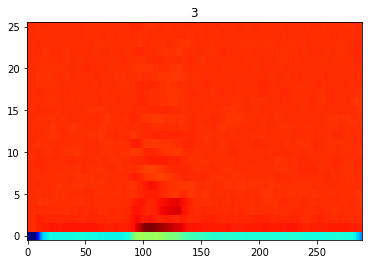

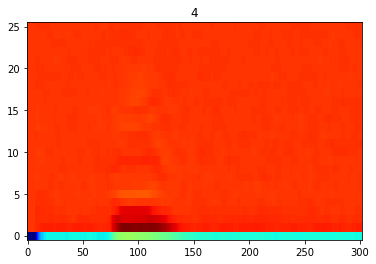

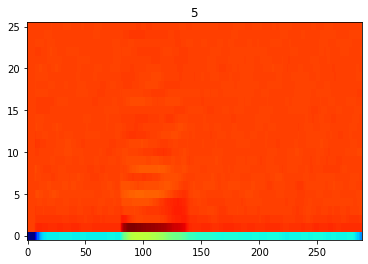

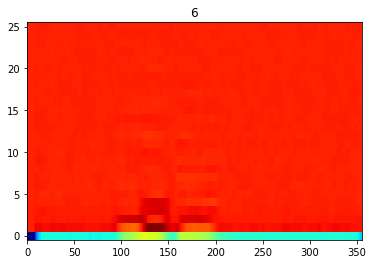

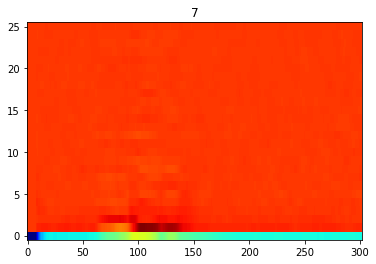

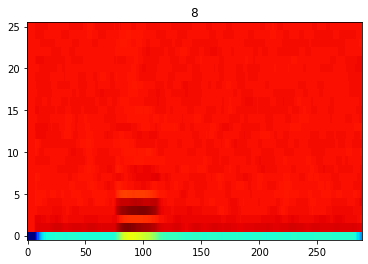

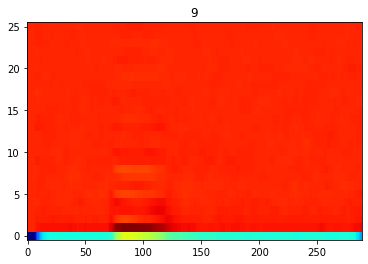

In [48]:
for key in db:
    feats = db[key]
    plt.imshow(feats, origin = 'lower', cmap = 'jet')
    plt.title(key)
    plt.axis('tight')
    plt.show()

## Benchmark 

In order to run the benchmark, we first write a function that can retrieve the ground truth answer to the query of interest

In [60]:
def retrieveAnswer(pathname):
    """
    Helper function that takes in a .mp3 file whose name is a list of the digits spoken in the file and returns a 
    list of the characters
    
    Inputs:
    pathname - the pathname of the file of interest
    
    Outputs:
    answer - a list of the digits in the mp3's file name
    """
    
    basename = os.path.basename(pathname)[:-4]
    answer = [int(digit) for digit in list(basename)]
    
    
    return answer

Working out splitting algo, etc

Going to use 32834 query as a test

In [52]:
audio, sr = lb.core.load('denoisedQueries/32834.mp3', sr = 22050)

In [53]:
S = lb.core.stft(audio, n_fft = 2048, hop_length = 128)

In [126]:
digitTimes = getDigitTimes('denoisedQueries/32834.mp3')
# digitTimes[:, 0] = digitTimes[:,0]*-1
# test = np.sum(digitTimes, axis = 1)
# print(digitTimes)
# print(test)
# digitTimes = np.delete(digitTimes, 1, 0 )
# print()
# print(digitTimes)

In [114]:
list(db.keys())[0]

'0'

In [161]:
def getMatchScores(audioQuery, db, sr = 22050, nfft = 2048, hop = 128, metric = 'euclidean'):
    """
    """
    
    #we begin by calculating the mfcc of the query
    S = lb.core.stft(audioQuery, n_fft = nfft, hop_length = hop)
    mfcc_query = mfcc(S, n_fft = nfft, sr = sr)
    
    #now we iterate through the database and compare all the numbers with subsequency dynamic time warping
    scores = []
    for key in db:
        
        mfcc_ref = db[key]
        
        D_num, wp_num = lb.sequence.dtw(mfcc_ref, mfcc_query, metric = metric)
        scores.append(np.min(D_num[-1:]))
        
#     predInd = np.argmin(scores)
#     predScore = scores[predInd]
    return scores

In [162]:
def getCleanedDigitsTimes(queryName, hop_length = 128, top_db = 25):
    """
    """
    
    #begin by getting the splits as well as how many splits there should be
    desiredSplits = len(retrieveAnswer(queryName))
    times = getDigitTimes(queryName, hop_length = hop_length, top_db = top_db)
    
    while times.shape[0] > desiredSplits:
        times_copy = np.copy(times)
        times_copy[:,0] = times_copy[:,0]*-1
        lengths = np.sum(times_copy, axis = 1)
        toRemove = np.argmin(lengths)
        
        times = np.delete(times, toRemove, 0)
        
    #if the times array started off less than the current array, just return an empty array (the benchmark will ignore it)
    if times.shape[0] < desiredSplits:
        times = np.array([])

    return times

In [163]:
def getPrediction(audioQuery, db, sr = 22050, nfft = 2048, hop = 128, metric = 'euclidean'):
    """
    """
    
    matchScores = getMatchScores(audioQuery, db, sr = sr, nfft = nfft, hop = hop, metric = metric)
    refList = list(db.keys())
    
    predInd = np.argmin(matchScores)
    prediction = int(refList[predInd])
    
    return prediction

In [164]:
def getPredictions(queryPath, db, sr = 22050, nfft = 2048, hop = 128, top_db = 25, metric = 'euclidean'):
    """
    """
    predictions = []
    times = getCleanedDigitsTimes(queryPath, hop_length = hop, top_db = top_db)
    
    if times.size == 0:
        return []
    
    audio, _ = lb.core.load(queryPath, sr)
    
    for i in range(times.shape[0]):
        startTime = times[i, 0]
        endTime = times[i, 1]
        audioClip = audio[startTime:endTime]
        currPred = getPrediction(audioClip, db, sr = sr, nfft = nfft, hop = hop, metric = metric)
        
        predictions.append(currPred)
        
    return predictions

In [165]:
print(getPredictions('denoisedQueries/32834.mp3', db))

[3, 8, 8, 3, 4]


In [166]:
def runBenchmark(indir, db, Mac = False, sr = 22050, nfft = 2048, hop = 128, top_db = 25, metric = 'euclidean'):
    """
    Runs a benchmark for our system 
    
    Inputs:
    indir - the directory where the mp3 queries are located
    
    Output:
    confusionMatrix - a 10x10 confusion matrix, where the row indicates the digit guess, and the 
    column indicates the ground truth
    """
    
    confusionMatrix = np.zeros((10,10))
    
    #we begin by retrieving all the paths to our queries
    mp3s = retrieveMP3s(indir, Mac = Mac)
    
    calcsDone = len(mp3s)
    for i in range(len(mp3s)):
        
        currPath = mp3s[i]
        predictions = getPredictions(currPath, db, sr = sr, nfft = nfft, hop = hop, top_db = top_db, metric = metric)
        
        if len(predictions) == 0:
            calcsDone -= 1
            pass
        
        answers = retrieveAnswer(currPath)
        
        assert(len(answers) == len(predictions))
        
        for j in range(len(answers)):
            confusionMatrix[predictions[j], answers[j]] += 1
                    
    return confusionMatrix, calcsDone

In [167]:
#done w/ euclidean similarity metric
confusionMatrix, calcsDone = runBenchmark('denoisedQueries', db) 

In [168]:
print(confusionMatrix)
print()
print(calcsDone)

[[45.  0. 22.  3.  1.  0. 42. 59.  1.  0.]
 [ 0. 23.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 14. 57.  2.  0.  1.  0.  0.  2.]
 [ 1. 29.  1.  0. 57.  0.  2.  0.  2.  0.]
 [ 0. 16.  0.  0.  0. 64.  0.  1.  0. 19.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. 22.  4.  2.  0.  0.  0. 50.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.  1. 26.]]

100


In [169]:
#done w/ cosine similarity metric
confusionMatrix_c, calcsDone_c = runBenchmark('denoisedQueries', db, metric = 'cosine') 

In [170]:
print(confusionMatrix_c)
print()
print(calcsDone_c)

[[44.  0.  4.  0.  0.  0. 25. 54.  0.  0.]
 [ 0. 28.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. 42.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. 38. 19. 64. 54. 39.  8.  0. 16. 26.]
 [ 0.  2.  0.  0.  8.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 25.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0. 11.  6.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  1.  0. 37.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.  1. 20.]]

100


In [57]:
playDigits('denoisedQueries/32834.mp3', digitTimes)

In [49]:
queries = retrieveMP3s("Queries")
references = retrieveMP3s("References")

In [58]:
mfcc_test = mfcc(S, num_coeffs = 20)

In [ ]:
plt.imshow(mfcc_test, cmap = "jet", origin = "lower")
plt.axis("tight")

In [ ]:
S_first = lb.core.stft(audio[17408:27776], n_fft = 2048, hop_length = 128)

In [ ]:
mfcc_first = mfcc(S_first, num_coeffs = 20)

In [ ]:
plt.imshow(mfcc_first, cmap = "jet", origin = "lower")
plt.axis("tight")

In [ ]:
reference_three, sr = lb.core.load('References/Reference_3.mp3', sr = 22050)

In [ ]:
ipd.Audio(reference_three, rate = 22050)

In [ ]:
S_reference = lb.core.stft(reference_three, n_fft = 2048, hop_length = 128)

In [ ]:
mfcc_ref = mfcc(S_reference, num_coeffs = 20)

In [ ]:
plt.imshow(mfcc_ref, cmap = "jet", origin = "lower")
plt.axis("tight")

In [ ]:
D, wp = lb.sequence.dtw(mfcc_ref, mfcc_first)

In [ ]:
import librosa.display
lb.display.specshow(D, x_axis='frames', y_axis='frames')
plt.plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')

In [ ]:
plt.plot(D[-1, :] / wp.shape[0])

In [ ]:
np.min(D[-1,:])

In [ ]:
reference_four, sr = lb.core.load('References/Reference_4.mp3', sr = 22050)

In [ ]:
S_ref4 = lb.core.stft(reference_four, n_fft = 2048, hop_length = 128)

In [ ]:
mfcc_ref4 = mfcc(S_ref4, num_coeffs = 20)

In [ ]:
D4, wp4 = lb.sequence.dtw(mfcc_ref4, mfcc_first)

In [ ]:
np.min(D4[-1,:])

In [ ]:
print(references)

In [ ]:
for i in range(len(references)):
    print(references[i])
    reference_num, sr = lb.core.load(references[i], sr = 22050)
    S_refNum = lb.core.stft(reference_num, n_fft = 2048, hop_length = 128)
    mfcc_refNum = mfcc(S_refNum, num_coeffs = 20)
    D_num, wp_num = lb.sequence.dtw(mfcc_refNum, mfcc_first)
    print(np.min(D_num[-1:]))

In [88]:
def getMatchScores(mfccQuery, references):
    storage = []
    for i in range(len(references)):
        #print(references[i])
        reference_num, sr = lb.core.load(references[i], sr = 22050)
        S_refNum = lb.core.stft(reference_num, n_fft = 2048, hop_length = 128)
        mfcc_refNum = mfcc(S_refNum, num_coeffs = 20)
        D_num, wp_num = lb.sequence.dtw(mfcc_refNum, mfccQuery)
        storage.append(np.min(D_num[-1:]))
        #print(np.min(D_num[-1:]))
    minPos = np.argmin(storage)
    print(references[minPos])
    #return storage

In [89]:
#S_first = lb.core.stft(audio[17408:27776], n_fft = 2048, hop_length = 128, n_fft = 2048, hop_length = 128)
#answer = retrieveAnswer('Queries/32824.mp3')
def analyzeQuery(audio, times, references, originalAudio):
    answer = retrieveAnswer(originalAudio)
    
    for i in range(len(times)):
        t = times[i]
        print(answer[i])
        #print(t[0])
        #print(t[])
        S_query = lb.core.stft(audio[t[0]:t[1]], n_fft = 2048, hop_length = 128)
        mfcc_query = mfcc(S_query, num_coeffs = 20)
        getMatchScores(mfcc_query, references)


In [86]:
answer

NameError: name 'answer' is not defined

In [128]:
analyzeQuery(audio, digitTimes, references, 'denoisedQueries/32834.mp3')

3
References\Reference_3.mp3
2
References\Reference_8.mp3
8
References\Reference_8.mp3
3
References\Reference_3.mp3
4
References\Reference_4.mp3


In [ ]:
audio2, sr = lb.core.load('denoisedQueries/73914130_denoised.mp3', sr = 22050)

In [ ]:
digitTimes2 = getDigitTimes('denoisedQueries/73914130_denoised.mp3')


In [ ]:
playDigits('denoisedQueries/73914130_denoised.mp3', digitTimes2)

In [ ]:
analyzeQuery(audio2, digitTimes2, references, 'Queries/73914130.mp3')

In [ ]:
audio3, sr = lb.core.load('denoisedQueries/77777_denoised.mp3', sr = 22050)

In [ ]:
digitTimes3 = getDigitTimes('denoisedQueries/77777_denoised.mp3')


In [ ]:
playDigits('denoisedQueries/77777_denoised.mp3', digitTimes3)

In [ ]:
analyzeQuery(audio3, digitTimes3, references, 'Queries/77777.mp3')

In [ ]:
audio4, sr = lb.core.load('denoisedQueries/9963437165_denoised.mp3', sr = 22050)
digitTimes4 = getDigitTimes('denoisedQueries/9963437165_denoised.mp3')
playDigits('denoisedQueries/9963437165_denoised.mp3', digitTimes4)
# This has a problem since six was split in half rip

In [ ]:
audio5, sr = lb.core.load('denoisedQueries/4084782589_denoised.mp3', sr = 22050)
digitTimes5 = getDigitTimes('denoisedQueries/4084782589_denoised.mp3')
playDigits('denoisedQueries/4084782589_denoised.mp3', digitTimes5)


In [ ]:
analyzeQuery(audio5, digitTimes5, references, 'Queries/4084782589.mp3')

In [ ]:
audio6, sr = lb.core.load('denoisedQueries/123454321_denoised.mp3', sr = 22050)
digitTimes6 = getDigitTimes('denoisedQueries/123454321_denoised.mp3')
playDigits('denoisedQueries/123454321_denoised.mp3', digitTimes6)

In [ ]:
analyzeQuery(audio6, digitTimes6, references, 'Queries/123454321.mp3')

In [ ]:
audio7, sr = lb.core.load('denoisedQueries/0123456789_denoised.mp3', sr = 22050)
digitTimes7 = getDigitTimes('denoisedQueries/0123456789_denoised.mp3')
digitTimes7 = np.delete(digitTimes7, 7, axis=0) # manually removed six that was split in half
playDigits('denoisedQueries/0123456789_denoised.mp3', digitTimes7)

In [ ]:
analyzeQuery(audio7, digitTimes7, references, 'Queries/0123456789.mp3')